In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from collections import OrderedDict
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix,accuracy_score

In [8]:
train_df=pd.read_csv("data/optdigits.tra",header=None)
test_df=pd.read_csv("data/optdigits.tes",header=None)
train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,64
0,0,1,6,15,12,1,0,0,0,7,...,0,0,0,6,14,7,1,0,0,0
1,0,0,10,16,6,0,0,0,0,7,...,0,0,0,10,16,15,3,0,0,0
2,0,0,8,15,16,13,0,0,0,1,...,0,0,0,9,14,0,0,0,0,7
3,0,0,0,3,11,16,0,0,0,0,...,0,0,0,0,1,15,2,0,0,4
4,0,0,5,14,4,0,0,0,0,0,...,0,0,0,4,12,14,7,0,0,6


In [9]:
class Preprocessor:
    def __init__(self):
        self.features=[]
    def fit(self,data):
        for i in range(data.shape[1]):
            if np.any(data[:,i]):
                self.features.append(i)
        return data[:,self.features]
    def transform(self,data):
        return data[:,self.features]

def plot_data(data,labels):
    plt.clf()
    color=list(colors.TABLEAU_COLORS.keys())
    plt.figure(figsize=(20,20))
    for x,y,label in zip(data[:,0],data[:,1],labels):
        plt.scatter(x,y,c=color[label],label=label)
        plt.annotate(label,(x,y))
    plt.xlabel("First dimension")
    plt.ylabel("Second dimension")

    handles, labels = plt.gca().get_legend_handles_labels()
    legend=[]
    for handle,label in zip(handles,labels):
        legend.append((label,handle))
    legend=sorted(legend,key=lambda x:x[0])
    by_label = OrderedDict(legend)
    plt.legend(by_label.values(), by_label.keys())
    plt.show()
preprocessor=Preprocessor()
x_train=train_df.iloc[:,:-1].values
p_x_train=preprocessor.fit(x_train)
y_train=train_df.iloc[:,-1].values
x_test=test_df.iloc[:,:-1].values
y_test=test_df.iloc[:,-1].values

### Q1. Implement the k-means clustering algorithm yourself in python. Cluster the training set k=10 and k=20 clusters. Run your clustering algorithm 10 times and report the reconstruction errors on training and test datasets for each run and for each value of k=10 and k=20 (number of clusters).

In [10]:
class KMeans:
    def __init__(self,k,iterations):
        self.k=k
        self.iterations=iterations
        self.means=[]
    def fit(self,training_data): 
        #Select random data points for k centroids 
        indices=np.random.choice(training_data.shape[0],size=self.k)
        self.means=training_data[indices]
        self.reconstruction_errors=[0]*self.iterations
        #Initialiize cluster results
        clusters=np.zeros([len(training_data)])
        for i in range(self.iterations):
            error=0
            for j in range(training_data.shape[0]):
                #Calculate distance between data point and cluster centroids
                distances=np.linalg.norm(training_data[j]-self.means,axis=1)
                #Select the centroid with least distance
                error+=np.min(distances)
                clusters[j]=np.argmin(distances)
            #Recalculate cluster centroids
            for j in range(self.k):
                vectors=training_data[clusters==j]
                self.means[j]=vectors.mean(axis=0)
            self.reconstruction_errors[i]=error
        return clusters
    

In [11]:
print("K-Means with K=10")
kmeans10=KMeans(10,10)
clusters10=kmeans10.fit(x_train)
print("Reconstruction errors:",kmeans10.reconstruction_errors)
print("\n\nK-Means with K=20")
kmeans20=KMeans(20,10)
clusters20=kmeans20.fit(x_train)
print("Reconstruction errors:",kmeans20.reconstruction_errors)

K-Means with K=10
Reconstruction errors: [134428.59249044498, 102740.91161771675, 100081.27106353224, 99505.15467738158, 99084.36480587139, 98615.17477500514, 98196.27316352271, 97915.943026509, 97750.9599033852, 97565.23024126868]


K-Means with K=20
Reconstruction errors: [113098.98536188602, 92335.64929028832, 90505.74011983606, 89532.4847809132, 88658.57749255374, 87934.03293411496, 87600.50733485655, 87480.68812490988, 87475.0200388905, 87446.49872013611]


### Q2. Implement PCA (Principal Component Analysis) algorithm yourself. Reduce the dimensionality of the training set by means of computing the parameters required by PCA on the training set. Display the training set using the first two projected dimensions of the dataset and compare with the plot in the textbook.

In [12]:
class PCA:
    def __init__(self):
        pass
    def fit(self,training_data):
        #Compute covariance matrix
        covariance_matrix=np.cov(training_data.transpose())
        #Calculate eigen values and eigen vectors
        eigen_values,eigen_vectors=np.linalg.eig(covariance_matrix)
        #Sort eigen vectors in the decreasing order of eigenvalues 
        eigen_vectors=eigen_vectors.transpose()
        self.components=eigen_vectors[eigen_values.argsort()[::-1]]
        self.components=self.components.T
    def transform(self,training_data,n_components=2):
        w=self.components[:,:n_components]
        mean=np.mean(training_data,axis=0)
        result=np.zeros((training_data.shape[0],n_components))
        for i in range(training_data.shape[0]):
            result[i]=np.dot(w.T,training_data[i]-mean)
        return np.array(result)

In [13]:
pca=PCA()
pca.fit(p_x_train)
reduced_data=pca.transform(p_x_train)

<Figure size 432x288 with 0 Axes>

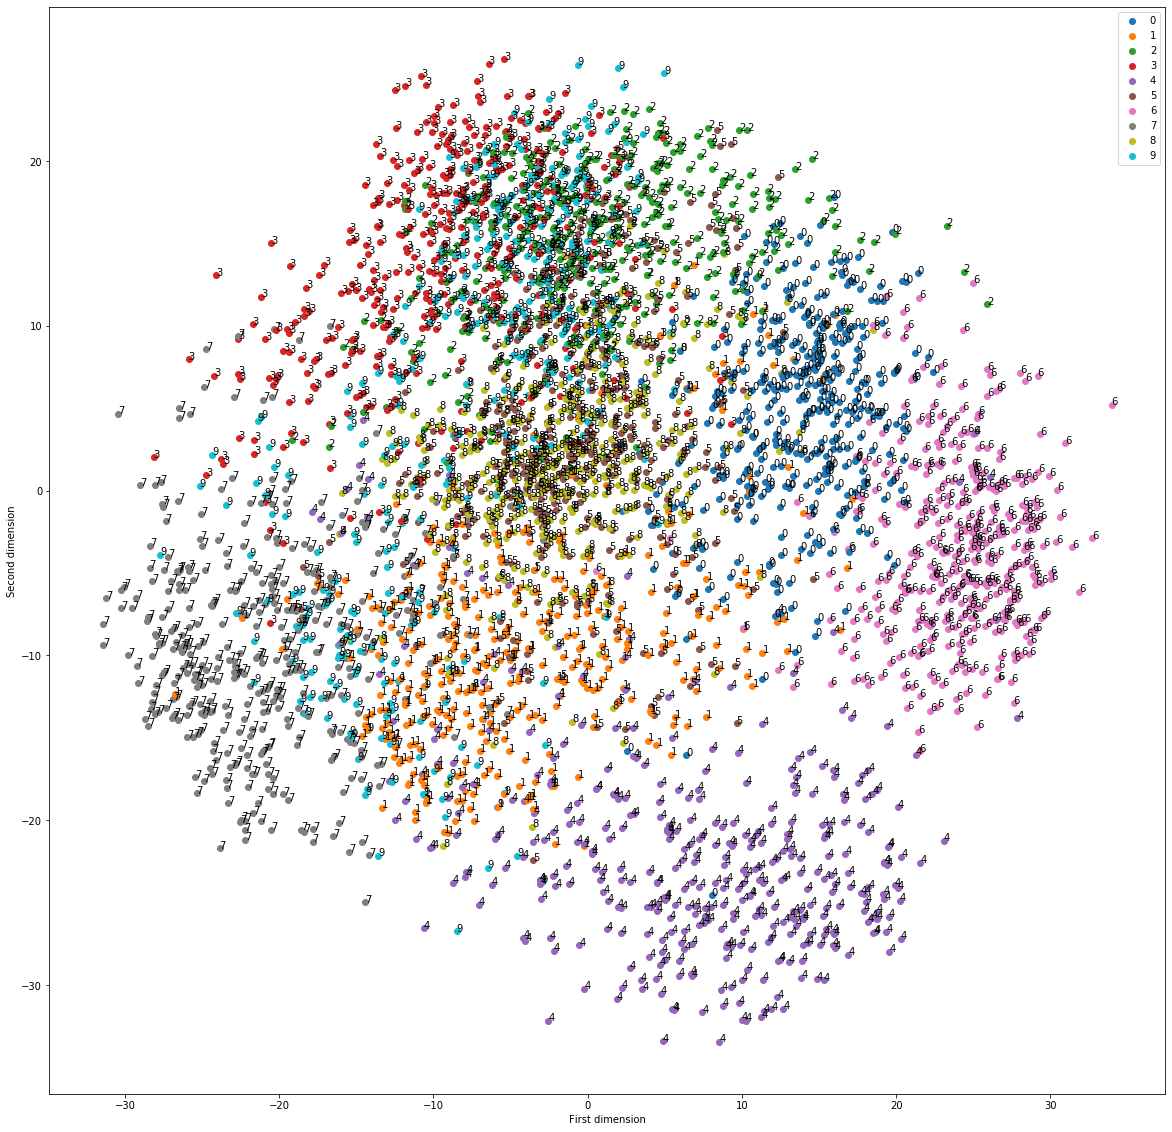

In [14]:
plot_data(reduced_data,y_train)

### Q3. Implement LDA (Linear Discriminant Analysis) algorithm yourself. Reduce the dimensionality of the training set by means of computing the parameters required by LDA on the training set. Display the training set using the first two projected dimensions of the dataset and compare with the plot in the textbook.

In [15]:
class LDA:
    def __init__(self):
        self.means=None
        self.components=None
    def fit(self,x_train,y_train):
        no_of_features=x_train.shape[1]
        self.means=np.zeros((no_of_features,no_of_features))
        S_B=np.zeros((no_of_features,no_of_features))
        S_W=np.zeros((no_of_features,no_of_features))
        for i in np.unique(y_train):
            self.means[i]=np.mean(x_train[y_train==i],axis=0)
            matrix=np.zeros((no_of_features,no_of_features))
            for row in x_train[y_train==i]:
                row=row.reshape((no_of_features,1))
                mean=self.means[i].reshape((no_of_features,1))
                matrix+=((row-mean).dot((row-mean).T))
            S_W+=matrix
        overall_mean=np.mean(x_train,axis=0)
        overall_mean=overall_mean.reshape((no_of_features,1))
        for i in np.unique(y_train):
            mean_i=self.means[i].reshape((no_of_features,1))
            n=len(x_train[y_train==i])
            S_B+=(n*(mean_i-overall_mean).dot((mean_i-overall_mean).T))
        eigen_values,eigen_vectors=np.linalg.eig(np.dot(np.linalg.inv(S_W),S_B))
        eigen_vectors=eigen_vectors.real
        self.components=eigen_vectors[:,eigen_values.argsort()[::-1]]
    def transform(self,x_train,n_components=2):
        W=self.components[:,:n_components]
        return np.dot(x_train,W)

<Figure size 432x288 with 0 Axes>

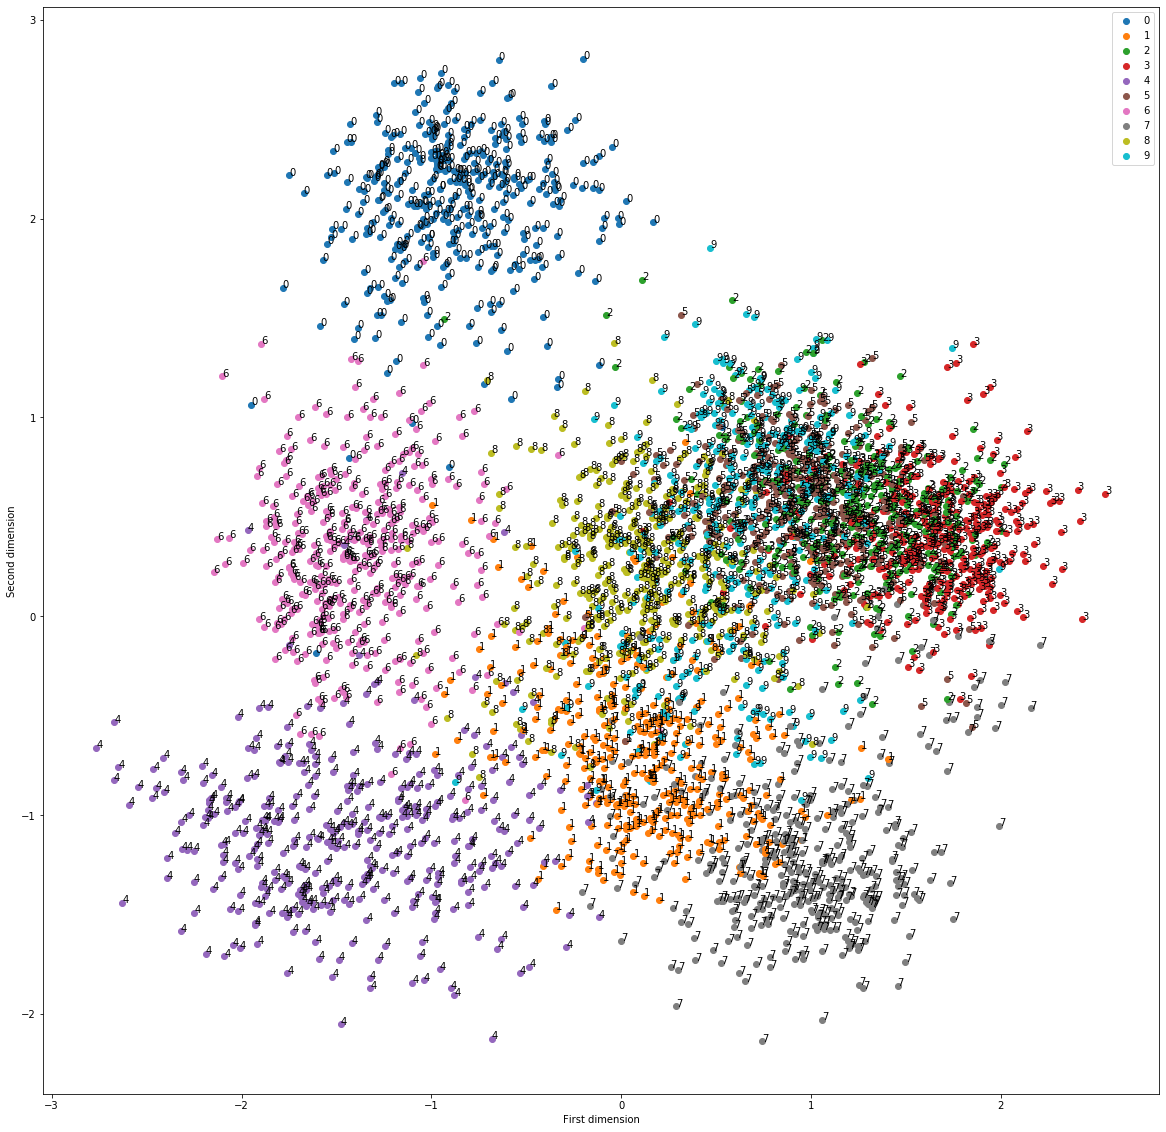

In [16]:
lda=LDA()
lda.fit(p_x_train,y_train)
reduced_data=lda.transform(p_x_train)
plot_data(reduced_data,y_train)

### Q4. Use knn (k nearest neighbor) classification algorithm with k=3, 5, 15 to predict the class labels (0, 1, 2, …, 9) for the original test set (in 64 dimensions) using the original training set as the training dataset. Compute the confusion matrix and also the test error for each class (0, 1, 2, ….,9) on the test dataset. 

In [17]:
def KNNClassifierResults(x_train,y_train,x_test,y_test,n_neighbors):
    print("Input dimension:",x_train.shape[1])
    error_data=[]
    for n in n_neighbors:
        classifier=KNeighborsClassifier(n_neighbors=n)
        classifier.fit(x_train,y_train)
        y_pred=classifier.predict(x_test)
        print("Confusion matrix for n={0}:\n".format(n),confusion_matrix(y_test,y_pred))
        print("\n"*2)
        errors=[]
        for label in np.unique(y_test):
            errors.append(1-accuracy_score(y_test[y_test==label],y_pred[y_test==label]))
        error_data.append(errors)
    df=pd.DataFrame(np.transpose(error_data),columns=["K="+str(n) for n in n_neighbors])
    print("Test error for each class:")
    print(df)
    print("\n"*3)
    

In [18]:
KNNClassifierResults(x_train,y_train,x_test,y_test,n_neighbors=[3,5,15])

Input dimension: 64
Confusion matrix for n=3:
 [[178   0   0   0   0   0   0   0   0   0]
 [  0 180   0   0   0   0   1   0   1   0]
 [  0   4 173   0   0   0   0   0   0   0]
 [  0   0   0 181   0   0   0   1   1   0]
 [  0   2   0   0 178   0   0   0   1   0]
 [  0   0   0   1   1 179   0   0   0   1]
 [  0   0   0   0   0   0 181   0   0   0]
 [  0   0   0   0   0   0   0 172   1   6]
 [  0   9   0   1   0   0   0   0 162   2]
 [  0   0   0   4   0   1   0   0   1 174]]



Confusion matrix for n=5:
 [[178   0   0   0   0   0   0   0   0   0]
 [  0 181   0   0   0   0   1   0   0   0]
 [  0   3 174   0   0   0   0   0   0   0]
 [  0   1   0 178   0   1   0   1   2   0]
 [  0   1   0   0 179   0   0   0   1   0]
 [  0   0   0   0   1 180   0   0   0   1]
 [  0   0   0   0   0   1 180   0   0   0]
 [  0   0   0   0   0   0   0 173   1   5]
 [  0   8   0   2   0   1   0   0 162   1]
 [  0   0   0   2   1   1   0   0   2 174]]



Confusion matrix for n=15:
 [[178   0   0   0   0   0   0 

### Q5a)  PCA projected test set (PCA parameters computed on the training set) in 2, 5, 9 dimensions. 

In [19]:
print("PCA 2 dimensions")
KNNClassifierResults(pca.transform(p_x_train,2),y_train,pca.transform(preprocessor.transform(x_test),n_components=2),y_test,n_neighbors=[3,5,15])
print("PCA 5 dimensions")
KNNClassifierResults(pca.transform(p_x_train,5),y_train,pca.transform(preprocessor.transform(x_test),n_components=5),y_test,n_neighbors=[3,5,15])
print("PCA 9 dimensions")
KNNClassifierResults(pca.transform(p_x_train,9),y_train,pca.transform(preprocessor.transform(x_test),n_components=9),y_test,n_neighbors=[3,5,15])


PCA 2 dimensions
Input dimension: 2
Confusion matrix for n=3:
 [[134   9   5   0   2   8  12   0   8   0]
 [ 20 122   2   0   3  12   1   7   5  10]
 [  5  10  82  31   1  15   0   0   5  28]
 [  0   0  37 104   0  12   0   7   2  21]
 [  1  14   0   2 161   1   2   0   0   0]
 [ 10  34  36  10   2  39   0   0  44   7]
 [ 19   3   0   0   5   0 154   0   0   0]
 [  0  34   3   5   7   7   0 107   1  15]
 [  8  46  19  10   1  31   0   2  50   7]
 [  1  15  60  39   4  12   0  10   6  33]]



Confusion matrix for n=5:
 [[139   3   8   0   2   9  11   0   6   0]
 [ 22 117   4   0   5  12   0  11   6   5]
 [  4   9  84  37   0  13   0   0  10  20]
 [  0   0  31 114   1   9   0   8   7  13]
 [  0  15   0   2 162   0   1   0   0   1]
 [  9  29  30   6   2  47   0   1  52   6]
 [ 20   2   0   0   4   0 155   0   0   0]
 [  0  34   1   4   6   5   0 118   1  10]
 [  7  44  10   4   0  37   0   2  59  11]
 [  0  13  47  41   4  21   0  12   6  36]]



Confusion matrix for n=15:
 [[141   3   8 

### Q5b)  LDA projected test set (LDA parameters computed on the training set) in 2, 5, 9 dimensions. 

In [20]:
print("LDA 2 dimensions")
KNNClassifierResults(lda.transform(p_x_train,2),y_train,pca.transform(preprocessor.transform(x_test),n_components=2),y_test,n_neighbors=[3,5,15])
print("LDA 5 dimensions")
KNNClassifierResults(lda.transform(p_x_train,5),y_train,pca.transform(preprocessor.transform(x_test),n_components=5),y_test,n_neighbors=[3,5,15])
print("LDA 9 dimensions")
KNNClassifierResults(lda.transform(p_x_train,9),y_train,pca.transform(preprocessor.transform(x_test),n_components=9),y_test,n_neighbors=[3,5,15])


LDA 2 dimensions
Input dimension: 2
Confusion matrix for n=3:
 [[  7   0   0 154   0   0   1  16   0   0]
 [  3   0   0  25 128   0   0  26   0   0]
 [160   0   0   6  10   0   1   0   0   0]
 [160   1   0   1  21   0   0   0   0   0]
 [  1   0   0   0  22   0   0 158   0   0]
 [ 71   0   0  19  62   0   7  23   0   0]
 [  0   0   0 137   0   0   0  44   0   0]
 [  1   0   0   0 178   0   0   0   0   0]
 [ 52   1   1  13  78   0  10  18   0   1]
 [143   0   0   0  35   0   2   0   0   0]]



Confusion matrix for n=5:
 [[  5   0   0 153   0   0   1  19   0   0]
 [  2   0   0  26 127   0   0  27   0   0]
 [153   0   0  12  11   0   1   0   0   0]
 [160   1   0   1  21   0   0   0   0   0]
 [  1   0   0   0  18   0   0 162   0   0]
 [ 74   0   0  18  61   0   5  24   0   0]
 [  0   0   0 126   0   0   0  55   0   0]
 [  1   0   0   0 178   0   0   0   0   0]
 [ 57   1   0  13  77   1   6  18   0   1]
 [144   0   0   0  35   0   1   0   0   0]]



Confusion matrix for n=15:
 [[  6   0   0 

### Q5c)  Does using PCA or LDA help with the test error of the knn? If so, for which classes does it help most? 

No.
Using PCA or LDA does not reduce the test error of KNN.